# Kaggle NBA Week 3 - Ron Au

#### Options:

In [517]:
# Activate cell to enable module imports if not running notebook within Docker
# Enter command mode by pressing Esc key, then press Y key to re-enable this cell
# To disable this cell, enter command mode and press R key

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [518]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Set MLflow experiment and run

In [519]:
from mlflow import set_tracking_uri, set_experiment, start_run, end_run, log_metric, log_params, log_artifacts

# Clean up any leftover runs
end_run()

set_tracking_uri('http://localhost:5000')
set_experiment(experiment_name='kaggle-nba')

## Read data, set features and set target

In [520]:
import pandas as pd

df = pd.read_csv('../data/raw/train.csv')
dfc = df.copy()

target = dfc.loc[:, 'TARGET_5Yrs':]
dfc = dfc.loc[:, 'GP':'TOV']

## Data preparation and feature engineering

In [521]:
from src.features.data_features import engineer

start_run(run_name='Final Run')

features = {
    'new_neg': False, # Impute negative values
    'new_upsample': False, # Upsample with smote
    'new_downsample': True, # Downsample randomly
    'new_pct': False, # Replace % column data with own recalculations
    'add_POS': False, # Add Possessions
    'add_PPP': False, # Add Points per Possessions
    'add_3PP': False, # Add 3-pointers per 100 Possessions
    'add_FGP': False, # Add Field Goals per 100 Possessions
    'add_FTG': False, # Add Free Throws per Games
    'add_3PR': False, # Add 3-Pointer % > 75% of mean
    'add_FGR': False, # Add Field Goal % > 75% of mean
    'add_FTR': False, # Add Free Throw % > 75% of mean
    'add_RONM': False, # Add RON per 100 Minutes
    'add_RONP': False, # Add RON per Possessions
    'rem_PTS': False, # Remove Points per Game
    'rem_pct': False # Remove 3P%, FP% and FT%
}

# Log which features were engineered to MLflow
log_params(features)

dfc, target = engineer(dfc, target, features)

## Standardise data set

In [522]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dfc = scaler.fit_transform(dfc)

## Split training, test and validation sets

In [523]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfc, target, test_size=0.2, random_state=5)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

## Train logistic regression model

In [524]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

## Baseline results

## Model results

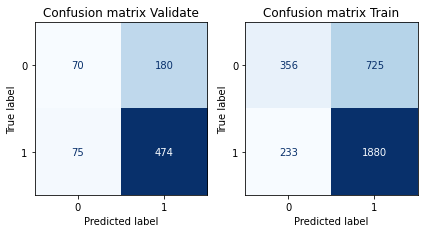

LogisticRegression(n_jobs=-1)


In [525]:
from src.models.eval_model import eval_model

model, roc_score_training, roc_score_val, acc_train, acc_val = eval_model(log_reg, X_train, y_train, X_test, y_test)

In [526]:
# Log metrics to MLflow and end run
log_metric('AUROC_Train', roc_score_training)
log_metric('AUROC_Test', roc_score_val)
log_metric('Acc_Train', acc_train)
log_metric('Acc_Test', acc_val)
end_run()

## Save results to CSV

In [527]:
from src.models.save_predictions import save_predictions

test_data = pd.read_csv('../data/raw/test.csv')
test_data = test_data.loc[:, 'GP':'TOV']
test_data, _ = engineer(test_data, None, features, predicting=True)
test_data = scaler.transform(test_data)

filename = 'au-ron_week3_log-reg'
save_predictions(f'{filename}.csv', log_reg, test_data)
pd.read_csv(f'../data/predictions/{filename}.csv')

Predictions saved to ../data/predictions/au-ron_week3_log-reg.csv


,Id,TARGET_5Yrs
0,0.0,0.655445
1,1.0,0.661111
2,2.0,0.822238
3,3.0,0.889530
4,4.0,0.542578
...,...,...
3794,3794.0,0.875596
3795,3795.0,0.650039
3796,3796.0,0.498853
3797,3797.0,0.892139
